In [75]:
#############
# LIBRARIES #
#############

import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white', {'axes.grid' : False})

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer, MinMaxScaler, RobustScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import sklearn

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from yellowbrick.target import FeatureCorrelation
from yellowbrick.features import rank1d, rank2d, RadViz, ParallelCoordinates
from yellowbrick.classifier import confusion_matrix, PrecisionRecallCurve, ClassificationReport, ClassPredictionError, ROCAUC, DiscriminationThreshold
from yellowbrick.model_selection import cv_scores, FeatureImportances

import pickle as pkl

import warnings
warnings.filterwarnings("ignore")

In [98]:
################
# Getting data #
################

data_path = '../Data/'
data = 'heart.csv'
file_path = os.path.join(data_path, data)

heart_df = pd.read_csv(file_path)
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [99]:
heart_df.Oldpeak.unique()

array([ 0. ,  1. ,  1.5,  2. ,  3. ,  4. ,  0.5,  2.5,  5. ,  0.8,  0.7,
        1.4,  2.1,  0.4,  0.2,  1.7,  2.2,  0.1,  1.6,  1.3,  0.3,  1.8,
        2.6, -0.9,  2.8, -2.6, -1.5, -0.1,  0.9,  1.1,  2.4, -1. , -1.1,
       -0.7, -0.8,  3.7,  1.2, -0.5, -2. ,  1.9,  3.5,  0.6,  3.1,  2.3,
        3.4,  3.6,  4.2,  3.2,  5.6,  3.8,  2.9,  6.2,  4.4])

#### Data dictionary:

- Age: age of the patient (years)
- Sex: sex of the patient (M: Male, F: Female)
- ChestPainType: chest pain type (TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic)
- RestingBP: resting blood pressure (mm Hg)
- Cholesterol: serum cholesterol (mm/dl)
- FastingBS: fasting blood sugar (1: if FastingBS > 120 mg/dl, 0: otherwise)
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved (Numeric value between 60 and 202)
- ExerciseAngina: exercise-induced angina (Y: Yes, N: No)
- Oldpeak: oldpeak = ST (Numeric value measured in depression)
- ST_Slope: the slope of the peak exercise ST segment (Up: upsloping, Flat: flat, Down: downsloping)
- HeartDisease: output class [1: heart disease, 0: Normal]

### 1. Basic dataset info

In [77]:
n_cols, n_rows = heart_df.shape[0], heart_df.shape[1]
# Checking for duplicate rows
dup_rows = heart_df.duplicated().sum()
# Checking for missing values
heart_df.isna().sum()

print(f'The dataset contains {n_rows} observations and {n_cols} columns.')
print('......................')
print(f'Total number of duplicated rows: {dup_rows}')
print('......................')
print(f'Total number of missing values in each column:')
print(heart_df.isna().sum())

The dataset contains 12 observations and 918 columns.
......................
Total number of duplicated rows: 0
......................
Total number of missing values in each column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [78]:
# Checking data types
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [79]:
# A brief look at makeup of columns values
heart_df.nunique()

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

In [80]:
# Let's get the uniue values for categorical features
columns = heart_df.select_dtypes(include='object').columns.tolist()
for col in columns:
    unique_values = heart_df[col].unique()
    counts = heart_df[col].value_counts().values
    print(f'The feature "{col}" contains {len(unique_values)} unique values: {(", ".join(unique_values))}: {[counts[i] for i in range(0, len(counts))]}')

The feature "Sex" contains 2 unique values: M, F: [725, 193]
The feature "ChestPainType" contains 4 unique values: ATA, NAP, ASY, TA: [496, 203, 173, 46]
The feature "RestingECG" contains 3 unique values: Normal, ST, LVH: [552, 188, 178]
The feature "ExerciseAngina" contains 2 unique values: N, Y: [547, 371]
The feature "ST_Slope" contains 3 unique values: Up, Flat, Down: [460, 395, 63]


In [81]:
# String values in the dataframe (e.g. sex, chestpain type, resting ECG, etc) are in the form of object. We'll we need to convert them to string.
cat_cols = heart_df.select_dtypes(include='object').columns
num_cols = heart_df.select_dtypes(exclude='object').columns
heart_df[cat_cols] = heart_df[cat_cols].astype('category')
heart_df['FastingBS'] = heart_df['FastingBS'].astype('category')
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             918 non-null    int64   
 1   Sex             918 non-null    category
 2   ChestPainType   918 non-null    category
 3   RestingBP       918 non-null    int64   
 4   Cholesterol     918 non-null    int64   
 5   FastingBS       918 non-null    category
 6   RestingECG      918 non-null    category
 7   MaxHR           918 non-null    int64   
 8   ExerciseAngina  918 non-null    category
 9   Oldpeak         918 non-null    float64 
 10  ST_Slope        918 non-null    category
 11  HeartDisease    918 non-null    int64   
dtypes: category(6), float64(1), int64(5)
memory usage: 49.4 KB


In [82]:
num_cols = heart_df.select_dtypes(exclude='category').columns
num_cols

Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease'], dtype='object')

In [83]:
# Basic statistics about numberical features
heart_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


In [84]:
# A resting BP of 0 and Cholosterol of 0 are likely an error; We'll remove these rows
heart_df = heart_df[heart_df['RestingBP'] != 0]
heart_df = heart_df[heart_df['Cholesterol'] != 0]
heart_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,746.0,52.882038,9.505888,28.0,46.00,54.0,59.0,77.0
RestingBP,746.0,133.022788,17.282750,92.0,120.00,130.0,140.0,200.0
Cholesterol,746.0,244.635389,59.153524,85.0,207.25,237.0,275.0,603.0
MaxHR,746.0,140.226542,24.524107,69.0,122.00,140.0,160.0,202.0
Oldpeak,746.0,0.901609,1.072861,-0.1,0.00,0.5,1.5,6.2
HeartDisease,746.0,0.477212,0.499816,0.0,0.00,0.0,1.0,1.0


In [85]:
n_cols, n_rows = heart_df.shape[0], heart_df.shape[1]
# Checking for duplicate rows
dup_rows = heart_df.duplicated().sum()
# Checking for missing values
heart_df.isna().sum()

print(f'The dataset contains {n_rows} observations and {n_cols} columns.')
print('......................')
print(f'Total number of duplicated rows: {dup_rows}')
print('......................')
print(f'Total number of missing values in each column:')
print(heart_df.isna().sum())

The dataset contains 12 observations and 746 columns.
......................
Total number of duplicated rows: 0
......................
Total number of missing values in each column:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


### 2. EDA and Feature Engineering

In [86]:
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


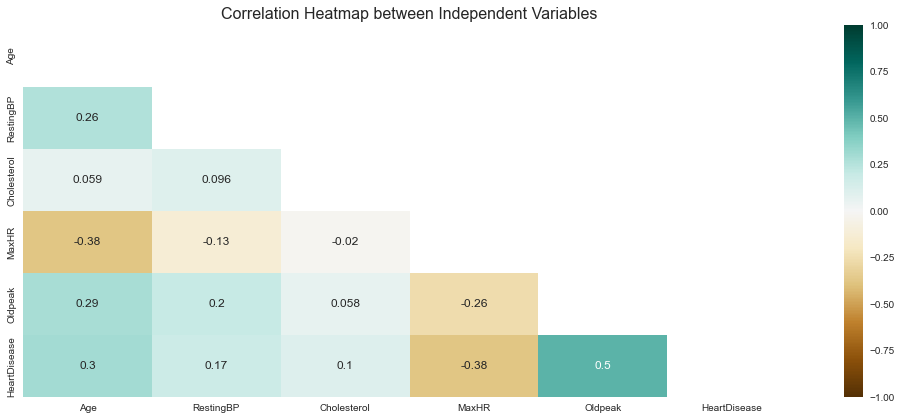

In [87]:
# Correlation between variables
plt.figure(figsize=(14, 6))
mask = np.triu(np.ones_like(heart_df.corr(), dtype=np.bool)) # defining the mask to set the values in the upper triangle to True
heatmap = sns.heatmap(heart_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap between Independent Variables', fontdict={'fontsize':16})
plt.tight_layout()
plt.savefig('../Plots/Correlation_Matrix.png', dpi=300)

In [88]:
feature =[]
colinear=[]
for col in heart_df.corr().columns:
    for i in heart_df.corr().index:
        if (heart_df.corr()[col][i]> .9 and heart_df.corr()[col][i] < 1) or (heart_df.corr()[col][i]< -.9 and heart_df.corr()[col][i] > -1):
                feature.append(col)
                colinear.append(i)
                print(Fore.RED + f"\033[1mmulticolinearity alert in between\033[0m {col} - {i}")

print('Analysis done!')
print('No colinearity issues found' if len(colinear) == 0 else '')


Analysis done!
No colinearity issues found


We see some weak correlation between independent variables. For example, Age and MaxHR are negatively correlated (the older you are, the lower your max heart rate) and positively correlated with RestingBP (the older you are the higher your resting blood pressure). None of the independent features show correlations high enough to justify removing from the model, without performing recursive feature elimimination.

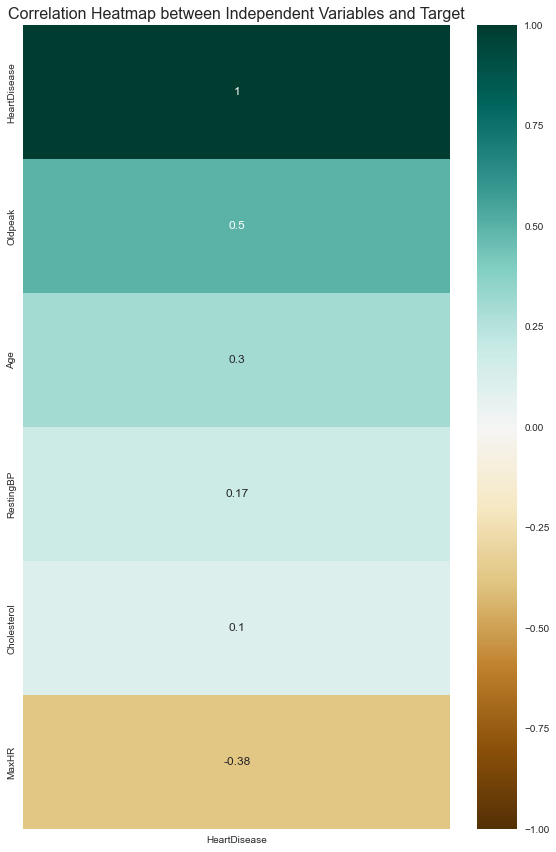

In [89]:
# Correlation between independent variables and dependent variable
heart_df.corr()[['HeartDisease']].sort_values(by='HeartDisease', ascending=False)

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(heart_df.corr()[['HeartDisease']].sort_values(by='HeartDisease', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap between Independent Variables and Target', fontdict={'fontsize':16})
plt.tight_layout()
plt.savefig('../Plots/Correlation_Matrix_Target.png', dpi=300)

Heart disease is positively correlated with OldPeak, age and blood sugar levels at fasting, and negatively correlated with max HR and cholesterol levels. These intuitively make sense based on what we know about CVD.

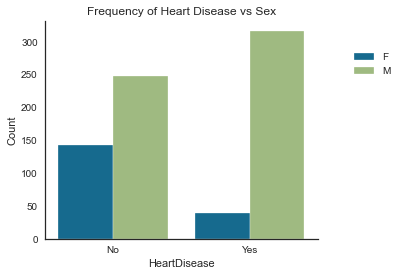

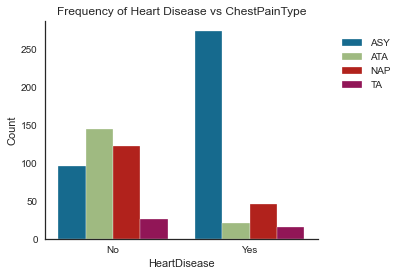

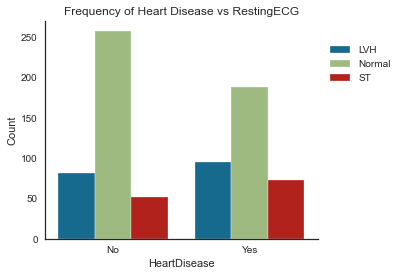

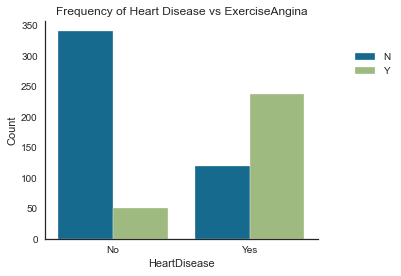

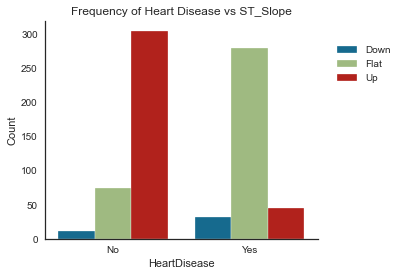

In [90]:
# Looking at the distrubution of the data for heart disease

for cat in cat_cols:
    plt.figure(figsize=(6,4))
    g = sns.countplot(data = heart_df, x = "HeartDisease", hue=cat)
    g.set_title(f'Frequency of Heart Disease vs {cat}')
    labels = [item.get_text() for item in g.get_xticklabels()]
    labels = ['No', 'Yes']
    g.set_xticklabels(labels)
    g.set_ylabel('Count')
    g.legend(loc='right', bbox_to_anchor=(1.3, 0.8))
    plt.tight_layout()
    sns.despine()
    plt.savefig(f'../Plots/Frequency of Heart Disease vs {cat}.png', dpi=300)
    plt.show()

[]

<Figure size 1080x720 with 0 Axes>

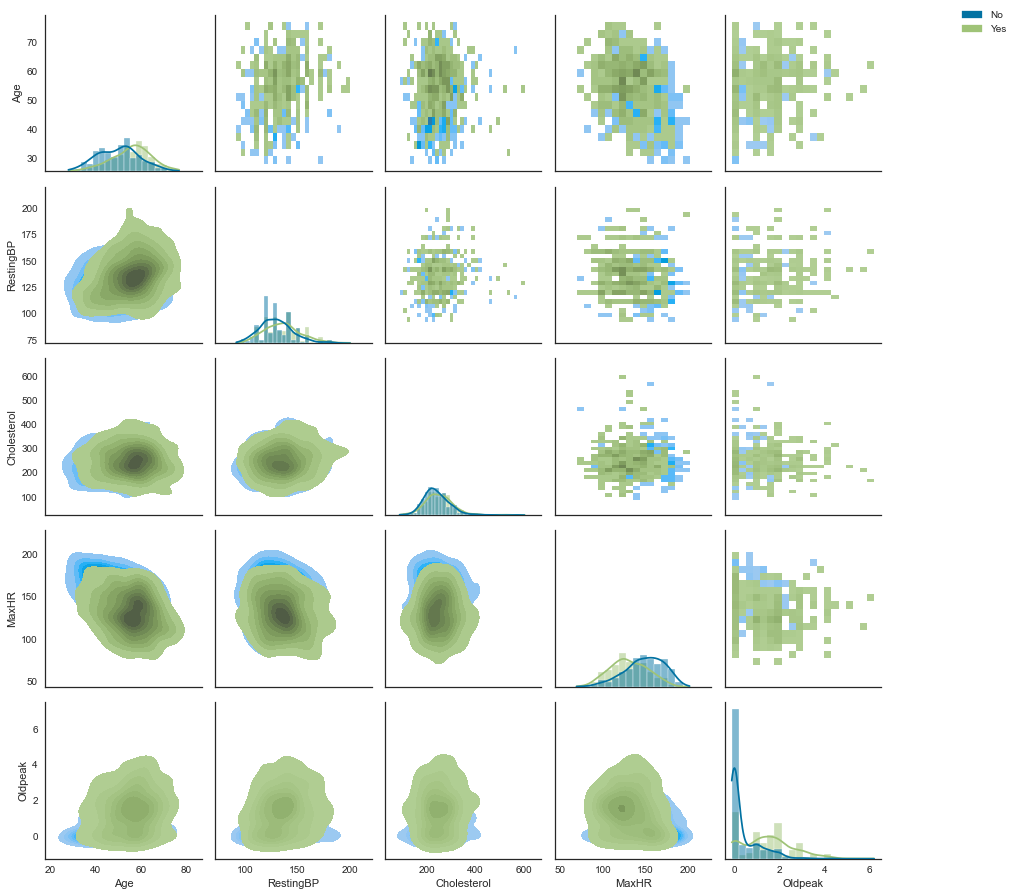

In [91]:
# Looking at pairwise bivariate distributions
plt.figure(figsize=(15,10))
g = sns.PairGrid(heart_df, hue="HeartDisease")
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)
handles = g._legend_data.values()
labels = g._legend_data.keys()
labels = ['No', 'Yes']
g.fig.legend(handles=handles, labels=labels, loc='upper center', ncol=1, bbox_to_anchor=(1.10, 1.0))
plt.tight_layout()
plt.savefig(f'../Plots/Pairwise Bivariate Distributions.png', dpi=300)
plt.plot()

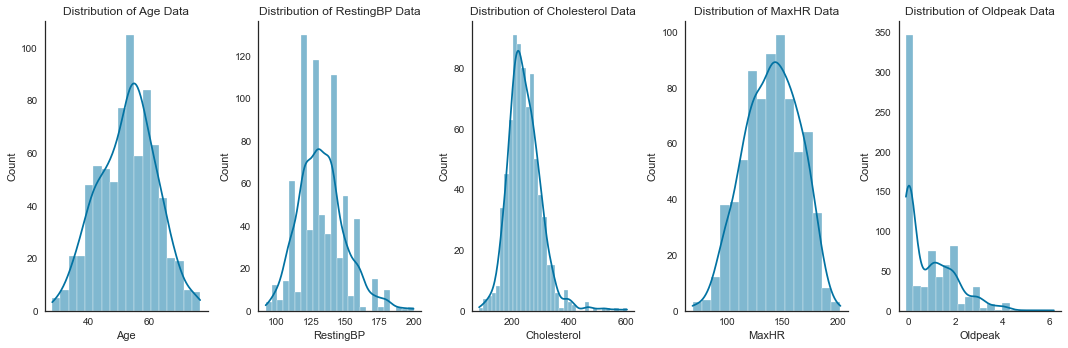

In [92]:
plt.figure(figsize=(15,5))
for i, col in enumerate(heart_df[num_cols].drop('HeartDisease', axis=1), 1):
    plt.subplot(1,5,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(heart_df[col], kde=True)
    plt.tight_layout()
    sns.despine()
    plt.plot()
plt.savefig(f'../Plots/Distribution of {col} Data before Transformation.png', dpi=300)

In [93]:
# Transforming Old Peak
pt = PowerTransformer()
# transformed_OldPeak = np.log(heart_df[['Oldpeak']]  +1)
transformed_OldPeak = pt.fit_transform(heart_df[['Oldpeak']])
transformed_Cholesterol = pt.fit_transform(heart_df[['Cholesterol']])
transformed_RestingBP = np.log(heart_df[['RestingBP']])
heart_df['Oldpeak'] = transformed_OldPeak
heart_df['Cholesterol'] = transformed_Cholesterol
heart_df['RestingBP'] = transformed_RestingBP

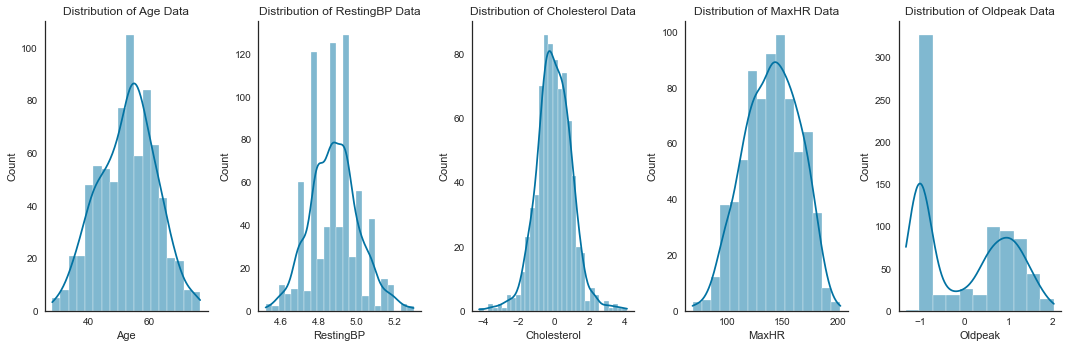

In [94]:
# After transforming
plt.figure(figsize=(15,5))
for i, col in enumerate(heart_df[num_cols].drop('HeartDisease', axis=1), 1):
    plt.subplot(1,5,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(heart_df[col], kde=True)
    plt.tight_layout()
    sns.despine()
    plt.plot()
plt.savefig(f'../Plots/Distribution of {col} Data after Transformation.png', dpi=300)

In [95]:
for col in num_cols.drop('HeartDisease'):
    print(f'{col} data')
    print(f'Skweness: {heart_df[col].skew()}; Kurtosis: {heart_df[col].kurtosis()}')
    print('---')


Age data
Skweness: -0.10293238550202193; Kurtosis: -0.3874252256784807
---
RestingBP data
Skweness: 0.1987182024596507; Kurtosis: 0.18376877494432353
---
Cholesterol data
Skweness: 0.009721390520346705; Kurtosis: 1.6036362739256864
---
MaxHR data
Skweness: -0.16516659777488013; Kurtosis: -0.5524281481320799
---
Oldpeak data
Skweness: 0.19244425752218206; Kurtosis: -1.6104944634783052
---


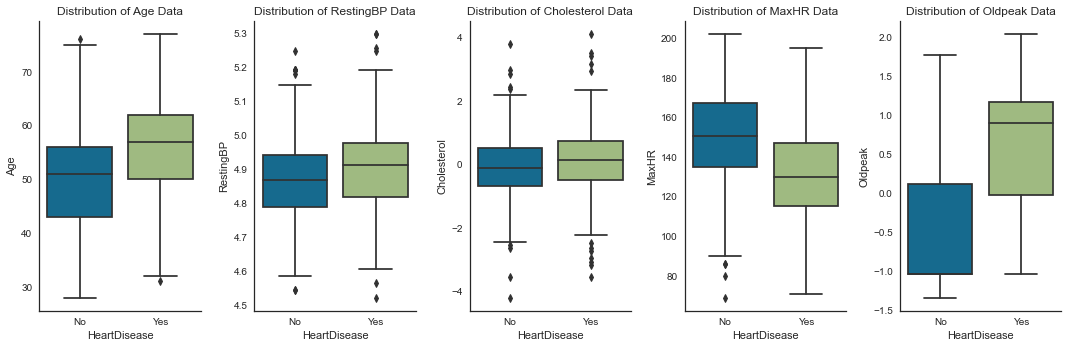

In [96]:
# Looking for outliers
plt.figure(figsize=(15,5))
for i, col in enumerate(heart_df[num_cols].drop('HeartDisease', axis=1), 1):
    plt.subplot(1,5,i)
    g = sns.boxplot(x="HeartDisease", y=col, data=heart_df)
    g.set_title(f"Distribution of {col} Data")
    labels = [item.get_text() for item in g.get_xticklabels()]
    labels = ['No', 'Yes']
    g.set_xticklabels(labels)
    sns.despine()
    plt.tight_layout()
    plt.plot()
plt.savefig(f'../Plots/Box Plots of Features.png', dpi=300)

#### Insights from EDA

- Target variable (Heart Disease) has close to balanced data.
- Numerical features are weakly to moderately correlated with the target variable.
- Oldpeak (depression related number) has a positive correlation with the heart disease.
- Maximum heart rate has negative correlation with the heart disease.
- Cholesterol is positively correlated with the heart disease.
- Men are more likely to have a heart disease than women.
- The type of chest pain is correlated with heart disease: someone experiencing Asymptomatic chest pain is more likely to have heart disease than someone with ATA Atypical Angina chest pain.
- Someone with ST-T wave abnormality is more likely to have heart disease than the others.
- Someone with exercise-induced angina is more likley to have heart disaese.
- Someone with ST_Slope Up is less likely to have heart disease.

### 3. Feature Engineering

In [23]:
enc_heart_df = heart_df.copy()
enc_heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,4.941642,0.824328,0,Normal,172,N,-1.028308,Up,0
1,49,F,NAP,5.075174,-1.185369,0,Normal,156,N,0.537785,Flat,1
2,37,M,ATA,4.867534,0.733608,0,ST,98,N,-1.028308,Up,0
3,48,F,ASY,4.927254,-0.460074,0,Normal,108,Y,0.902602,Flat,1
4,54,M,NAP,5.010635,-0.851129,0,Normal,122,N,-1.028308,Up,0


In [24]:
enc_heart_df.dtypes

Age                  int64
Sex               category
ChestPainType     category
RestingBP          float64
Cholesterol        float64
FastingBS         category
RestingECG        category
MaxHR                int64
ExerciseAngina    category
Oldpeak            float64
ST_Slope          category
HeartDisease         int64
dtype: object

In [25]:
enc_heart_df.dtypes
categorical_columns = enc_heart_df.select_dtypes('category').columns

enc = OrdinalEncoder()
encoder = enc.fit(enc_heart_df[categorical_columns])
enc_heart_df[categorical_columns] = encoder.transform(enc_heart_df[categorical_columns])

In [26]:
encoder.categories_

[array(['F', 'M'], dtype=object),
 array(['ASY', 'ATA', 'NAP', 'TA'], dtype=object),
 array([0, 1]),
 array(['LVH', 'Normal', 'ST'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['Down', 'Flat', 'Up'], dtype=object)]

In [27]:
enc_heart_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,1.0,1.0,4.941642,0.824328,0.0,1.0,172,0.0,-1.028308,2.0,0
1,49,0.0,2.0,5.075174,-1.185369,0.0,1.0,156,0.0,0.537785,1.0,1
2,37,1.0,1.0,4.867534,0.733608,0.0,2.0,98,0.0,-1.028308,2.0,0
3,48,0.0,0.0,4.927254,-0.460074,0.0,1.0,108,1.0,0.902602,1.0,1
4,54,1.0,2.0,5.010635,-0.851129,0.0,1.0,122,0.0,-1.028308,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,1.0,3.0,4.700480,0.434201,0.0,1.0,132,0.0,0.700478,1.0,1
914,68,1.0,0.0,4.969813,-0.894303,1.0,1.0,141,0.0,1.611121,1.0,1
915,57,1.0,0.0,4.867534,-2.490290,0.0,1.0,115,1.0,0.700478,1.0,1
916,57,0.0,1.0,4.867534,-0.045232,0.0,0.0,174,0.0,-1.028308,1.0,1


In [29]:
enc_heart_df.dtypes

Age                 int64
Sex               float64
ChestPainType     float64
RestingBP         float64
Cholesterol       float64
FastingBS         float64
RestingECG        float64
MaxHR               int64
ExerciseAngina    float64
Oldpeak           float64
ST_Slope          float64
HeartDisease        int64
dtype: object

In [30]:
enc_heart_df.shape

(746, 12)

In [31]:
# Getting features and target
X, y = enc_heart_df.drop(['HeartDisease'], axis=1), enc_heart_df[['HeartDisease']]

# Scaling the data
cols_to_scale = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']
scaler = RobustScaler()
# X_num_cols = X.select_dtypes(exclude='uint8').columns.tolist()
scaler.fit(X[cols_to_scale])
X[cols_to_scale] = scaler.transform(X[cols_to_scale])

In [32]:
X.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,-1.076923,1.0,1.0,0.480750,0.706636,0.0,1.0,0.842105,0.0,-1.028308,2.0
1,-0.384615,0.0,2.0,1.346990,-0.961040,0.0,1.0,0.421053,0.0,0.537785,1.0
2,-1.307692,1.0,1.0,0.000000,0.631356,0.0,2.0,-1.105263,0.0,-1.028308,2.0
3,-0.461538,0.0,0.0,0.387408,-0.359180,0.0,1.0,-0.842105,1.0,0.902602,1.0
4,0.000000,1.0,2.0,0.928318,-0.683683,0.0,1.0,-0.473684,0.0,-1.028308,2.0


In [33]:
y.head()

,HeartDisease
0,0
1,1
2,0
3,1
4,0


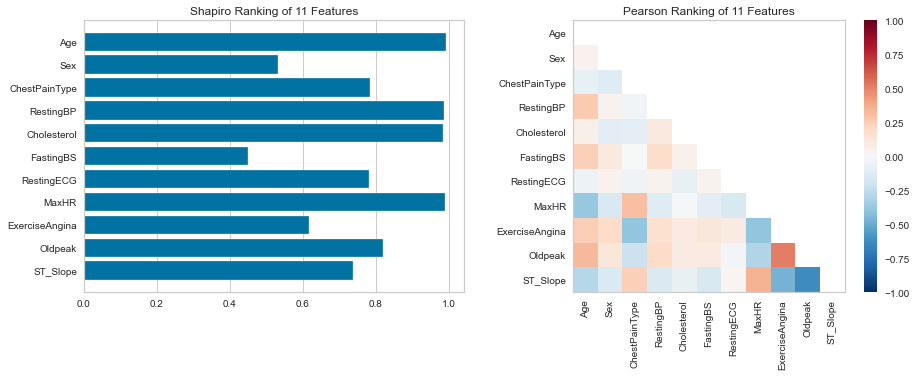

In [34]:
_, axes = plt.subplots(ncols=2, figsize=(15,5))

rank1d(X, ax=axes[0], show=False)
rank2d(X, ax=axes[1], show=False)
plt.show()

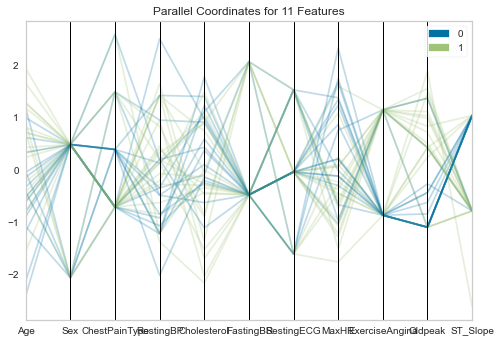

<AxesSubplot:title={'center':'Parallel Coordinates for 11 Features'}>

In [35]:
# Instantiate the visualizer
visualizer = ParallelCoordinates(
    normalize='standard', sample=0.05, shuffle=True,
)

# Fit the visualizer and display it
visualizer.fit_transform(enc_heart_df.drop(['HeartDisease'], axis=1), enc_heart_df['HeartDisease'])
visualizer.show()

In [36]:
y['HeartDisease'].unique()

array([0, 1])

In [37]:
# Splitting the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), random_state =0 ,stratify=y, test_size = 0.3)

In [38]:
X_train

array([[ 0.        ,  1.        ,  1.        , ...,  0.        ,
        -0.76626264,  2.        ],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         1.16180659,  1.        ],
       [ 0.53846154,  0.        ,  1.        , ...,  1.        ,
        -1.02830791,  2.        ],
       ...,
       [ 0.76923077,  0.        ,  0.        , ...,  1.        ,
        -1.02830791,  2.        ],
       [ 0.30769231,  1.        ,  2.        , ...,  1.        ,
         0.83997694,  1.        ],
       [ 0.15384615,  0.        ,  2.        , ...,  0.        ,
        -1.02830791,  2.        ]])

In [39]:
X_test

array([[ 0.46153846,  1.        ,  0.        , ...,  1.        ,
         0.90260212,  1.        ],
       [ 0.46153846,  1.        ,  0.        , ...,  1.        ,
         0.90260212,  0.        ],
       [ 0.76923077,  1.        ,  0.        , ...,  0.        ,
         1.16180659,  1.        ],
       ...,
       [ 0.38461538,  1.        ,  0.        , ...,  0.        ,
        -1.02830791,  2.        ],
       [-0.15384615,  1.        ,  0.        , ...,  0.        ,
        -1.02830791,  2.        ],
       [-1.15384615,  1.        ,  2.        , ...,  0.        ,
        -1.02830791,  2.        ]])

#### 3.1. Baseline Model

In [40]:
# Baseline Models
random_state = 123
accuracy =[]
model_names =[]

lr = LogisticRegression()
lda= LinearDiscriminantAnalysis()
svm = SVC()
knn = KNeighborsClassifier()
nb = GaussianNB()
xgb = XGBClassifier()
lgb = LGBMClassifier()
cat = CatBoostClassifier()
ada = AdaBoostClassifier()
rf = RandomForestClassifier(random_state=random_state)
gb = GradientBoostingClassifier()
ext = ExtraTreesClassifier(random_state=random_state)
sgd = SGDClassifier(random_state=random_state)
tree = DecisionTreeClassifier(random_state=random_state)
svc = SVC(random_state=random_state)

models = [lr, lda, svm, knn, nb, xgb, lgb, cat, ada, rf, gb, ext, sgd, tree, svc]

for model in models: 
    pipe = make_pipeline(model)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    accuracy.append(accuracy_score(y_test, y_pred))
    print (f'Model : {model} and  accuracy score is : {"{:.2%}".format(accuracy_score(y_test, y_pred))}')

model_names = ['Logistic','LinearDiscriminant','SVM','KNeighbors', 'GaussianNB', 'XGBoost', 'LGBoost', 'CatBoost', 'AdaBoost', 'RandomForest', 'GradientBoost', 'ExtraTrees', 'SGD', 'Decision Tree', 'SVC']
result_df = pd.DataFrame({'Accuracy':accuracy}, index=model_names).sort_values(by='Accuracy', ascending=False)
result_df

Model : LogisticRegression() and  accuracy score is : 83.04%
Model : LinearDiscriminantAnalysis() and  accuracy score is : 83.48%
Model : SVC() and  accuracy score is : 83.48%
Model : KNeighborsClassifier() and  accuracy score is : 83.48%
Model : GaussianNB() and  accuracy score is : 81.70%
[15:11:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_job

,Accuracy
CatBoost,0.861607
ExtraTrees,0.861607
RandomForest,0.843750
GradientBoost,0.843750
XGBoost,0.839286
LinearDiscriminant,0.834821
SVM,0.834821
KNeighbors,0.834821
LGBoost,0.834821
SVC,0.834821


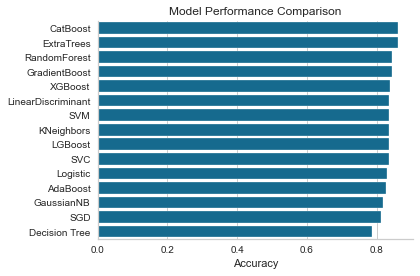

In [41]:
plt.figure(figsize=(6,4))
g = sns.barplot(data= result_df, y=result_df.index, x='Accuracy', orient = 'h', color='b')
g.set_title('Model Performance Comparison')
plt.tight_layout()
sns.despine()
plt.show()
 

In [42]:
model = ExtraTreesClassifier(random_state=random_state)
scoring = 'accuracy'
cross_validation = StratifiedKFold(n_splits=5, random_state=random_state, shuffle=True)
hyperparameters = {
        'n_estimators': range(25,151,25),
        'max_features': range(5,401,50),
        'min_samples_leaf': range(5,51,5),
        'min_samples_split': range(5,36,5),
    }
                            
gsc = GridSearchCV(
    estimator=model,
    param_grid=hyperparameters,
    scoring = scoring,
    cv=cross_validation
)

grid_result = gsc.fit(X_train, y_train)

print(f"Best {scoring} score: {grid_result.best_score_} using {grid_result.best_params_}")

# for test_mean, train_mean, param in zip(
#         grid_result.cv_results_['mean_test_score'],
#         grid_result.cv_results_['mean_train_score'],
#         grid_result.cv_results_['params']):
#     print("Train: %f // Test : %f with: %r" % (train_mean, test_mean, param))
    
model = ExtraTreesClassifier(**grid_result.best_params_, random_state=random_state)

model.fit(X_train, y_train)

Best accuracy score: 0.8697069597069597 using {'max_features': 5, 'min_samples_leaf': 5, 'min_samples_split': 20, 'n_estimators': 25}


ExtraTreesClassifier(max_features=5, min_samples_leaf=5, min_samples_split=20,
                     n_estimators=25, random_state=123)

In [43]:
best_extraTree = ExtraTreesClassifier(**grid_result.best_params_)
best_model = best_extraTree.fit(X_train, y_train)

In [44]:
d = {'Predictions': y_pred, 'Testing': y_test.reshape(-1)}
df = pd.DataFrame(data=d)
df

,Predictions,Testing
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
219,0,1
220,1,0
221,0,0
222,0,1


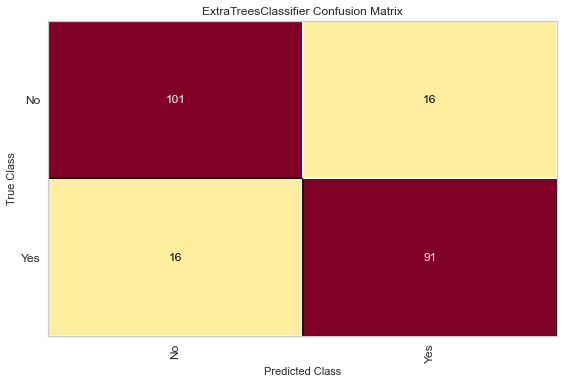

<Figure size 576x396 with 0 Axes>

In [45]:
model = best_model
confusion_matrix(
    model,
    X_train, y_train, X_test, y_test,
    classes=['No', 'Yes']
)
plt.tight_layout()

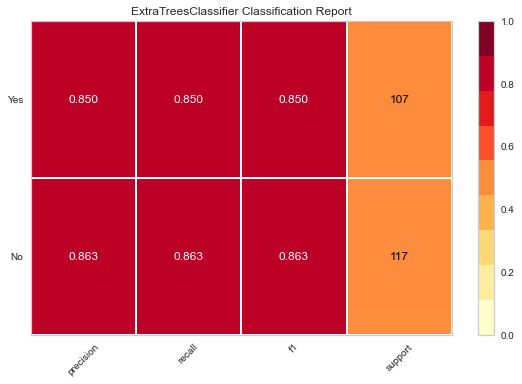

<AxesSubplot:title={'center':'ExtraTreesClassifier Classification Report'}>

In [46]:
# Instantiate the classification model and visualizer
classes = ["No", "Yes"]
model = best_model
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fitting the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluating the model on the test data
visualizer.show()

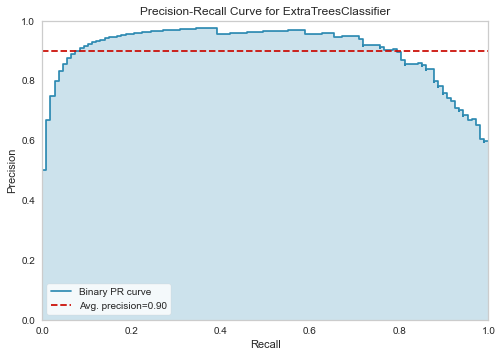

<AxesSubplot:title={'center':'Precision-Recall Curve for ExtraTreesClassifier'}, xlabel='Recall', ylabel='Precision'>

In [47]:
viz = PrecisionRecallCurve(best_model)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

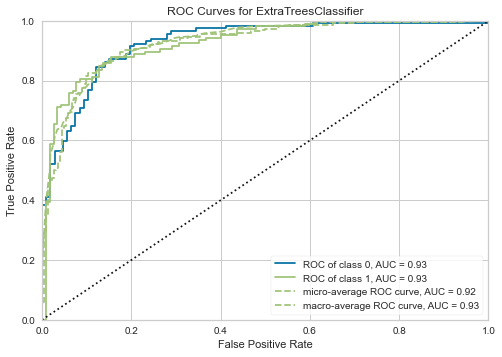

<AxesSubplot:title={'center':'ROC Curves for ExtraTreesClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [48]:
visualizer = ROCAUC(best_model)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and render the figure

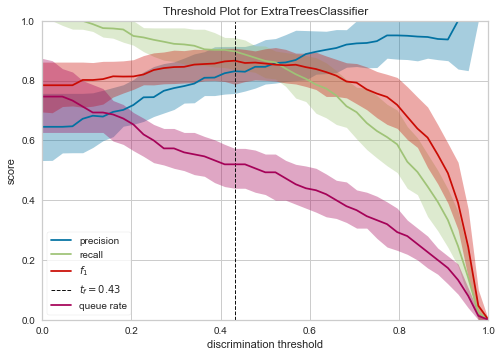

<AxesSubplot:title={'center':'Threshold Plot for ExtraTreesClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [49]:
# Instantiate the classification model and visualizer
visualizer = DiscriminationThreshold(best_model)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

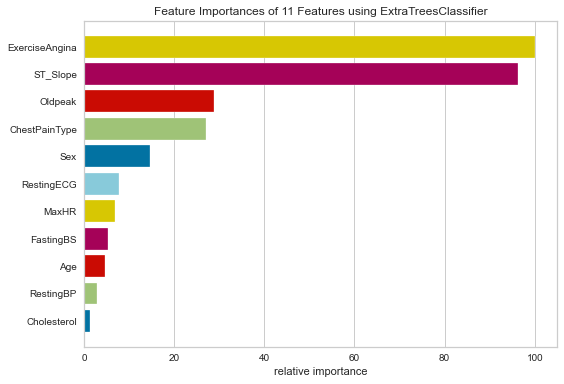

<AxesSubplot:title={'center':'Feature Importances of 11 Features using ExtraTreesClassifier'}, xlabel='relative importance'>

In [50]:
# Visualizing important features in the model
model = best_model
viz = FeatureImportances(model)
viz.fit(X, y)
viz.show()

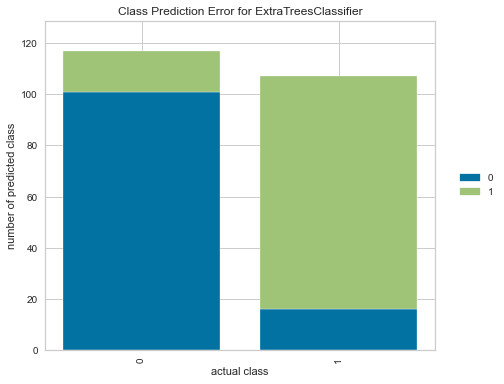

<AxesSubplot:title={'center':'Class Prediction Error for ExtraTreesClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [51]:
# Instantiate the classification model and visualizer
viz = ClassPredictionError(best_model)

viz.fit(X_train, y_train.reshape(-1))
viz.score(X_test, y_test.reshape(-1))
viz.show()

In [52]:
#List Hyperparameters that we want to tune.

leaf_size = list(range(1,50,1))
n_neighbors = list(range(1,30,1))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train,y_train)
#Print The value of best Hyperparameters
print(best_model.best_estimator_.get_params())

{'algorithm': 'auto', 'leaf_size': 1, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}


In [53]:
best_model.best_params_

{'leaf_size': 1, 'n_neighbors': 7, 'p': 1}

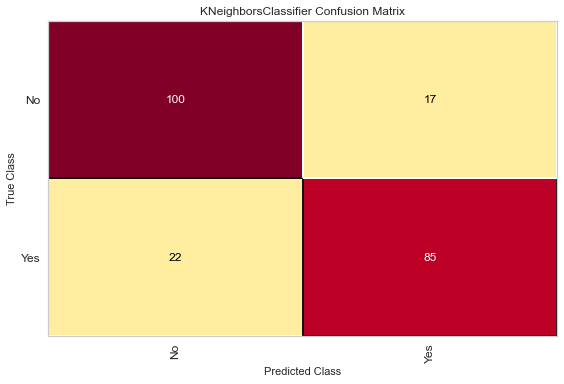

<Figure size 576x396 with 0 Axes>

In [54]:
# Instantiate the visualizer with the classification model
confusion_matrix(
    KNeighborsClassifier(n_neighbors=7, p=1, leaf_size=1),
    X_train, y_train, X_test, y_test,
    classes=['No', 'Yes']
)
plt.tight_layout()

In [55]:
neighbors = range(1, 50) # 1 to 20

# Setup algorithm
knn = KNeighborsClassifier()

# Loop through different neighbors values
for i in neighbors:
    knn.set_params(n_neighbors = i) # set neighbors value
    
    # Fit the algorithm
    print(f'Accuracy with {i} neighbors: {"{:.2%}".format(knn.fit(X_train, y_train).score(X_test, y_test))}')

Accuracy with 1 neighbors: 80.36%
Accuracy with 2 neighbors: 79.46%
Accuracy with 3 neighbors: 79.02%
Accuracy with 4 neighbors: 79.46%
Accuracy with 5 neighbors: 83.48%
Accuracy with 6 neighbors: 80.80%
Accuracy with 7 neighbors: 82.14%
Accuracy with 8 neighbors: 81.25%
Accuracy with 9 neighbors: 81.25%
Accuracy with 10 neighbors: 81.70%
Accuracy with 11 neighbors: 81.70%
Accuracy with 12 neighbors: 80.36%
Accuracy with 13 neighbors: 78.57%
Accuracy with 14 neighbors: 80.36%
Accuracy with 15 neighbors: 79.46%
Accuracy with 16 neighbors: 79.91%
Accuracy with 17 neighbors: 79.91%
Accuracy with 18 neighbors: 79.46%
Accuracy with 19 neighbors: 78.57%
Accuracy with 20 neighbors: 78.57%
Accuracy with 21 neighbors: 77.68%
Accuracy with 22 neighbors: 79.02%
Accuracy with 23 neighbors: 78.12%
Accuracy with 24 neighbors: 79.46%
Accuracy with 25 neighbors: 78.57%
Accuracy with 26 neighbors: 78.57%
Accuracy with 27 neighbors: 78.57%
Accuracy with 28 neighbors: 79.46%
Accuracy with 29 neighbors: 7

In [56]:
# defining parameter range 
param_grid = {'C': [0.1, 1,2, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf','linear']}  
  
gs_clf = GridSearchCV(SVC(), param_grid,cv=5, refit = True, verbose = 3) 
  
# fitting the model for grid search 
gs_clf.fit(X_train, y_train)

print(gs_clf.best_params_)

print(f"Accuracy score:{gs_clf.score(X_test,y_test)}%")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.581 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.552 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.567 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.615 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.548 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.848 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.800 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.827 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.865 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.885 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.867 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

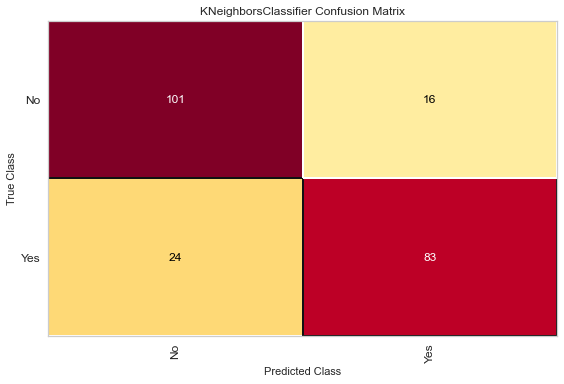

<Figure size 576x396 with 0 Axes>

In [57]:
# Instantiate the visualizer with the classification model
confusion_matrix(
    KNeighborsClassifier(n_neighbors=7),
    X_train, y_train, X_test, y_test,
    classes=['No', 'Yes']
)
plt.tight_layout()

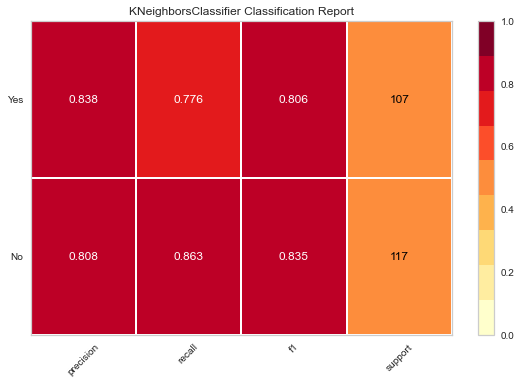

<AxesSubplot:title={'center':'KNeighborsClassifier Classification Report'}>

In [58]:
# Instantiate the classification model and visualizer
classes = ["No", "Yes"]
model = KNeighborsClassifier(n_neighbors=7)
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fitting the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluating the model on the test data
visualizer.show()

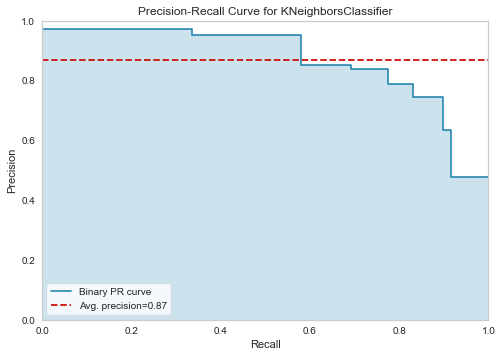

<AxesSubplot:title={'center':'Precision-Recall Curve for KNeighborsClassifier'}, xlabel='Recall', ylabel='Precision'>

In [59]:
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(KNeighborsClassifier(n_neighbors=7))
viz.fit(X_train, y_train)
viz.score(X_test, y_test)
viz.show()

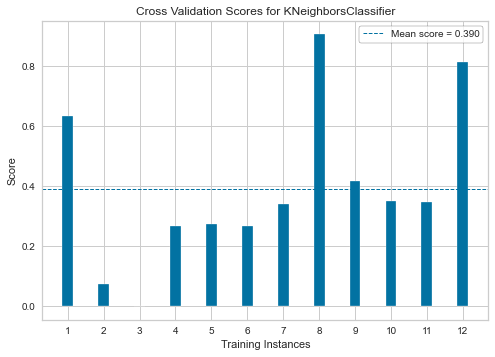

In [60]:
# Instantiate the regression model and visualizer
cv = KFold(n_splits=12, random_state=42, shuffle=True)

model = KNeighborsClassifier(n_neighbors=7)
visualizer = cv_scores(model, X_train, y_train, cv=cv, scoring='r2')

In [61]:
# visualizer = Rank2D(algorithm='pearson') # Instantiating the visualizer with the Pearson ranking algorithm

# visualizer.fit(X, y)
# visualizer.transform(X)
# visualizer.show()

In [74]:
# Final model, encoder and transformer
ext_final = ExtraTreesClassifier(max_features=5, min_samples_leaf=5, min_samples_split=20,
                     n_estimators=25, random_state=random_state)
best_model = ext_final.fit(X_train,y_train)
pkl.dump(best_model, open('../Model/final_model.pickle', 'wb'))

OldPeak_tranformer = pt.fit(heart_df[['Oldpeak']])
pkl.dump(OldPeak_tranformer, open('../Model/OldPeak_tranformer.pickle', 'wb'))

Cholesterol_transformer = pt.fit(heart_df[['Cholesterol']])
pkl.dump(Cholesterol_transformer, open('../Model/Cholesterol_transformer.pickle', 'wb'))

# Saving transformer and encoder
pkl.dump(encoder, open('../Model/feature_encoder.pickle', 'wb'))

### 4. Predictions

In [64]:
# Loading pickeled model
loaded_extraTree_model = pkl.load(open('../Model/final_model.pickle', 'rb'))
result = loaded_extraTree_model.score(X_test, y_test)
print(result)

0.8526785714285714


In [65]:
input_cols = heart_df.columns.drop('HeartDisease')
input_cols

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')

In [66]:
input_cols = heart_df.columns.drop('HeartDisease')

# User inputs
age = int(input('Enter your age: '))
sex = input('Enter your sex (M or F): ')
restingBP = int(input('Enter your resting blood pressure: '))
cholesterol = int(input('Enter your cholesterol level: '))
fastingBS = input('Is you blood sugar level above 120 dl/mg when fasting (Y or N): ')
MaxHR = int(input('Enter your max heart rate: '))
ExerciseAngina = input('Do you experience excercise-enduced engina (Y or N): ')
Oldpeak = int(input('Enter your old peak value: '))
ChestPainType = input('Describe you type of chest pains (ATA, NAP, ASY, TA): ')
ST_Slope = input('Enter your ST Slode (Up, Flat, Down): ')
RestingECG = input('Enter your resting ECG (Normal, ST, LVH): ')

In [67]:
user_input = {
                'Age': [age], 
                'Sex': [sex],
                'ChestPainType': ChestPainType, 
                'RestingBP': [restingBP], 
                'Cholesterol': cholesterol,
                'FastingBS': fastingBS,
                'RestingECG': RestingECG,
                'MaxHR': MaxHR,
                'ExerciseAngina': ExerciseAngina,
                'Oldpeak': Oldpeak,
                'ST_Slope': ST_Slope,
}
user_input_df = pd.DataFrame(user_input) # Creating a dataframe containing user inputs
user_input_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,20,M,ASY,100,100,N,Normal,200,N,0,Flat


In [68]:
user_input_df['FastingBS'] = np.where(user_input_df['FastingBS']=='No', 0, 1)
user_input_df['FastingBS'] = user_input_df['FastingBS'].astype('object') # Converting to type category for transforming
# Encoding and transforming user input
categorical_columns = user_input_df.select_dtypes('object').columns
user_input_df[categorical_columns] = user_input_df[categorical_columns].astype('category')
user_input_df[categorical_columns] = enc.transform(user_input_df[categorical_columns])

transformed_OldPeak = pt.transform(user_input_df[['Oldpeak']])
transformed_Cholesterol = pt.transform(user_input_df[['Cholesterol']])
transformed_RestingBP = np.log(user_input_df[['RestingBP']])
user_input_df['Oldpeak'] = transformed_OldPeak
user_input_df['Cholesterol'] = transformed_Cholesterol
user_input_df['RestingBP'] = transformed_RestingBP

user_input_df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
0,20,1.0,0.0,4.60517,98.549042,1.0,1.0,200,0.0,0.001364,1.0


In [69]:
prediction = loaded_extraTree_model.predict(user_input_df)
prediction_probability = loaded_extraTree_model.predict_proba(user_input_df).max()

if prediction[0] == 1:
    print(f'You are at risk for heart disease! --Determined with {"{:.0%}".format(prediction_probability)} confidence')
else: 
    print(f'You are NOT at risk for heart disease. --CDetermined with {"{:.0%}".format(prediction_probability)} confidence')

You are at risk for heart disease! --Determined with 70% confidence
